Sorry I use Japanese.  

PCAを使った時にだけLBスコアが下がってしまいます。（なぜかCVスコアはそこまで変わりない）  
リークしている可能性がありますが、どうしたらこのバグが治るかわかりません。  
アイデアがあったらぜひコメントで教えてください！

私が書いたコードは
・Training dataをfitし、transformで全体のデータを処理する
・CVの中のTraining dataをfitし、transformで全体のデータを処理する

という2つのものです。
後ろの処理は最後に載せます。

Import

In [ ]:
from typing import Any, Dict
import umap
import numpy as np
from scipy.sparse.csgraph import connected_components
from sklearn.decomposition import PCA
import os
import pandas as pd
import matplotlib.pyplot as plt
import warnings

import tensorflow as tf
from sklearn.decomposition import PCA

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Reshape, LayerNormalization, PReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import AveragePooling1D
from tensorflow.keras.layers import Dropout

from tensorflow.keras.constraints import max_norm
from tensorflow.keras import regularizers
import os
import lightgbm as lgb
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import KFold
import xgboost as xgb

In [ ]:
train = pd.read_csv("/kaggle/input/otto-group-product-classification-challenge/train.csv")
test = pd.read_csv("/kaggle/input/otto-group-product-classification-challenge/test.csv")
ss = pd.read_csv("/kaggle/input/otto-group-product-classification-challenge/sampleSubmission.csv")

In [ ]:
def docking(train: pd.DataFrame, test: pd.DataFrame) -> [pd.DataFrame, pd.Series]:
    print("docking")
    dict_a: Dict
    dict_a = {"Class_1": 0,
              "Class_2": 1,
              "Class_3": 2,
              "Class_4": 3,
              "Class_5": 4,
              "Class_6": 5,
              "Class_7": 6,
              "Class_8": 7,
              "Class_9": 8,
              }
    target = train["target"].map(dict_a)
    con_df = pd.concat([train, test], sort=False)
    """
    targetは Class_n　→ n-1　にした（1-9だったので）
    trainのcolumnsは feat_n → n にする
    """
    con_df = con_df.drop(["id", "target"], axis=1)
    con_df.columns = con_df.columns.map(lambda x: int(x[5:]))
    con_df = np.log1p(con_df)

    return con_df, target


def split_data(df, df_pca, df_features, target, join_pca: bool):
    # df = np.log1p(df)
    # df = pd.concat([df, df_pca], axis=1, join="inner")
    if join_pca:
        df = pd.concat([df, df_pca], axis=1, join_axes=[df.index])
    # df = df_pca.copy()

    df = pd.concat([df, df_features], axis=1, join_axes=[df.index])
    train_df = df[:len(target)]
    test_df = df[len(target):]
    return train_df, test_df


def make_features(df: pd.DataFrame):
    memo = pd.DataFrame()
    memo["count_zero"] = df[df == 0].count(axis=1)
    # memo["count_one"] = df[df == 1].count(axis=1)
    return memo


In [ ]:
def do_pca(df: pd.DataFrame, target: pd.Series):
    n = 10
    pca = PCA(n_components=n)
    pca.fit(df[:len(target)])
    # df_pca = pca.fit_transform(df)
    df_pca = pca.transform(df)
    n_name = [f"pca{i}" for i in range(n)]
    df_pca = pd.DataFrame(df_pca, columns=n_name)
    return df_pca

In [ ]:
df, target = docking(train, test)
df_pca = do_pca(df, target)
df_features = make_features(df)
df_train, df_test = split_data(df, df_pca, df_features, target, join_pca=True)

In [ ]:
train.head()

In [ ]:
df_train.head()

# Define Simple NN Model

In [ ]:
def nn_train_model(
        df: pd.DataFrame, target: pd.DataFrame, test: pd.DataFrame
):
    n_splits = 5
    num_class = 9
    epochs = 10
    lr_init = 0.01
    bs = 256
    num_features = df.shape[1]
    folds = KFold(n_splits=n_splits)

    model = tf.keras.models.Sequential([
        Input(shape=(num_features,)),
        Dense(128, kernel_initializer='glorot_uniform', activation="relu"),
        BatchNormalization(),
        Dropout(0.25),

        Dense(128, kernel_initializer='glorot_uniform', activation="relu"),
        BatchNormalization(),
        Dropout(0.25),

        Dense(64, kernel_initializer='glorot_uniform', activation="relu"),
        BatchNormalization(),
        Dropout(0.25),

        Dense(num_class, activation="softmax")
    ])
    
    # print(model.summary())
    optimizer = tf.keras.optimizers.Adam(lr=lr_init, decay=0.0001)

    """callbacks"""
    callbacks = []
    # callbacks.append(tf.keras.callbacks.LearningRateScheduler(lr_scheduler))
    # log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    # callbacks.append(tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1))

    model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
    preds = np.zeros((test.shape[0], num_class))
    for trn_idx, val_idx in folds.split(df, target):
        train_x = df.iloc[trn_idx, :].values
        val_x = df.iloc[val_idx, :].values
        train_y = target[trn_idx].values
        val_y = target[val_idx].values

        # train_x = np.reshape(train_x, (-1, num_features, 1))
        # val_x = np.reshape(val_x, (-1, num_features, 1))
        model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=epochs, verbose=2, batch_size=bs,
                  callbacks=callbacks)
        preds += model.predict(test.values) / n_splits

    return preds

# Training dataをfitし、transformで全体のデータを処理する


## Including PCA data
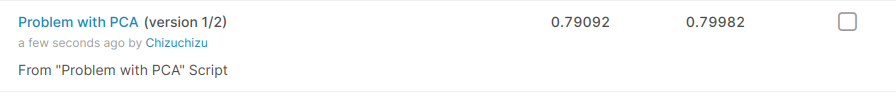

In [ ]:
pred1 = nn_train_model(df_train, target, df_test)

## Not including PCA data

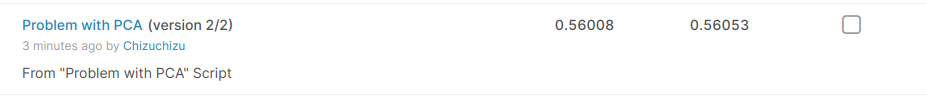

In [ ]:
df_train, df_test = split_data(df, df_pca, df_features, target, join_pca=False)
print(df_train.shape)
pred2 = nn_train_model(df_train, target, df_test)

# CVの中のTraining dataをfitし、transformで全体のデータを処理する

Not including PCA data(CVの中で追加するので)

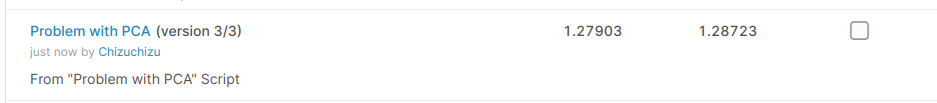

In [ ]:
def nn_train_model(
        df: pd.DataFrame, target: pd.DataFrame, test: pd.DataFrame
):
    n_splits = 5
    num_class = 9
    epochs = 10
    lr_init = 0.01
    bs = 256
    num_features = df.shape[1] + 10
    folds = KFold(n_splits=n_splits)

    model = tf.keras.models.Sequential([
        Input(shape=(num_features,)),
        Dense(128, kernel_initializer='glorot_uniform', activation="relu"),
        BatchNormalization(),
        Dropout(0.25),

        Dense(128, kernel_initializer='glorot_uniform', activation="relu"),
        BatchNormalization(),
        Dropout(0.25),

        Dense(64, kernel_initializer='glorot_uniform', activation="relu"),
        BatchNormalization(),
        Dropout(0.25),

        Dense(num_class, activation="softmax")
    ])
    
    # print(model.summary())
    optimizer = tf.keras.optimizers.Adam(lr=lr_init, decay=0.0001)

    """callbacks"""
    callbacks = []
    # callbacks.append(tf.keras.callbacks.LearningRateScheduler(lr_scheduler))
    # log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    # callbacks.append(tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1))

    model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
    preds = np.zeros((test.shape[0], num_class))
    for trn_idx, val_idx in folds.split(df, target):
        n = 10
        pca = PCA(n_components=n)
        pca.fit(df.iloc[trn_idx, :])
        n_name = [f"pca{i}" for i in range(n)]

        train_x = df.iloc[trn_idx, :]
        # memo = pd.DataFrame(pca.transform(train_x), columns=n_name)
        train_x = pd.concat([train_x, pd.DataFrame(pca.transform(train_x), columns=n_name)], axis=1,
                            join_axes=[train_x.index]).values

        val_x = df.iloc[val_idx]
        val_x = pd.concat([val_x, pd.DataFrame(pca.transform(val_x), columns=n_name)], axis=1,
                          join_axes=[val_x.index]).values

        train_y = target[trn_idx].values
        val_y = target[val_idx].values

        train_x = np.nan_to_num(train_x)
        val_x = np.nan_to_num(val_x)

        # train_x = np.reshape(train_x, (-1, num_features, 1))
        # val_x = np.reshape(val_x, (-1, num_features, 1))
        model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=epochs, verbose=2, batch_size=bs,
                  callbacks=callbacks)

        new_test = pd.concat([test, pd.DataFrame(pca.transform(test), columns=n_name)], axis=1,
                             join_axes=[test.index])
        preds += model.predict(new_test.values) / n_splits

    return preds

In [ ]:
pred3 = nn_train_model(df_train, target, df_test)

# Submit

In [ ]:
def make_submit_file(pred: np.ndarray, ss: pd.DataFrame) -> None:
    save_path = "submission.csv"
    ss.iloc[:, 1:] = pred
    ss.to_csv(save_path, index=None)

In [ ]:
SUBMIT = 3  # 1~3

if SUBMIT == 1:
    make_submit_file(pred, ss)
elif SUBMIT == 2:
    make_submit_file(pred2, ss)
else:
    make_submit_file(pred3, ss)